In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from pystruct.inference import compute_energy
from pystruct.inference.maxprod import iterative_max_product, tree_max_product
from pystruct.inference.inference_methods import inference_ad3, inference_qpbo, inference_max_product
from pystruct.utils import make_grid_edges
from pystruct.inference.lbp import lbp_plus, compute_energy_plus
import einops
from scipy import sparse
from functools import partial
from matplotlib import pyplot as plt

# Fast Implementation of LBP

## Tests on Potts Model

In [3]:
POTTS = 'POTTS'
CURRENT_CELL = POTTS

size = 10
n_states = 10

rnd = np.random.RandomState(2)
x = rnd.normal(size=(size, size, n_states))
binary_edges = make_grid_edges(x)
binary_potentials = rnd.normal(size=(binary_edges.shape[0], n_states, n_states))
unary_potentials = x.reshape(-1, n_states)
args = (unary_potentials, binary_potentials, binary_edges)
E = partial(compute_energy, *args)

### Benchmark on different methods

In [ ]:
assert CURRENT_CELL == POTTS

%timeit lbp_plus(*args)
%timeit lbp_plus(*args, max_iter=30)
%timeit iterative_max_product(*args)
# ad3 too slow, about 20s per loop
# %timeit inference_ad3(*args)

In [4]:
labels = lbp_plus(
    torch.tensor(unary_potentials, dtype=torch.float32), 
    torch.tensor(binary_potentials, dtype=torch.float32), 
    torch.tensor(binary_edges, dtype=torch.long)
)
print(labels)
print(E(labels))

tensor([8, 1, 9, 5, 3, 8, 5, 1, 3, 1, 6, 8, 5, 8, 5, 0, 8, 9, 9, 8, 3, 5, 6, 7,
        6, 2, 6, 8, 9, 8, 1, 7, 1, 9, 1, 3, 2, 1, 2, 3, 4, 2, 4, 8, 9, 3, 5, 5,
        7, 9, 7, 5, 2, 7, 1, 8, 6, 4, 4, 4, 6, 1, 3, 1, 6, 3, 5, 9, 9, 1, 0, 6,
        6, 8, 4, 8, 4, 5, 2, 6, 8, 3, 9, 3, 7, 4, 0, 4, 5, 6, 9, 9, 4, 6, 0, 6,
        9, 4, 8, 3])
305.28081933357555


In [5]:
assert CURRENT_CELL == POTTS

# larger is better
print("parallel")
print(E(lbp_plus(*args)))
print(E(lbp_plus(*args, track_best=True)))
print(E(lbp_plus(*args, max_iter=30, track_best=True)))
print("sequential")
print(E(iterative_max_product(*args)))
print(E(iterative_max_product(*args, track_best=True)))
print("ad3")
print(E(inference_ad3(*args)))

# not supported on Mac
# qpbo = inference_qpbo(*args)
# print(E(qpbo))

parallel
305.28081933357555
305.28081933357555
308.015437691316
sequential
309.4690626835955
309.4690626835955
ad3
297.59876799000085


### Benchmark on different hyper-parameters

/Users/admin/opt/miniconda3/envs/pystruct3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/admin/opt/miniconda3/envs/pystruct3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


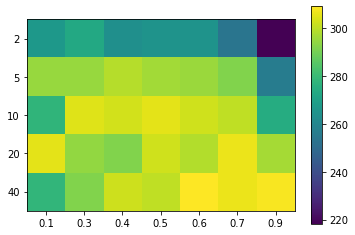

In [51]:
assert CURRENT_CELL == POTTS

iters = [2, 5, 10, 20, 40]
dampings = [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9]
energies = np.zeros(shape=[len(iters), len(dampings)])

for i, iter_num in enumerate(iters):
    for j, damping in enumerate(dampings):
        res = lbp_plus(*args, max_iter=iter_num, damping=damping)
        energies[i][j] = compute_energy_plus(*args, labels=res)

fig, ax = plt.subplots(1,1)

ax.imshow(energies)
img = ax.imshow(energies)

ax.set_yticklabels(list(map(str, [None] + iters)))
ax.set_xticklabels(list(map(str, [None] + dampings)))

plt.colorbar(img)

## Tests on Easy Linear-Chain

Only adajcent nodes have binary potentials, which should have exact solution (Viterbi).

In [52]:
EAXCT_LINEAR_CHAIN = 'EAXCT_LINEAR_CHAIN'
CURRENT_CELL = EAXCT_LINEAR_CHAIN

size = 25
n_states = 32

rnd = np.random.RandomState(2)
unary_potentials = np.abs(rnd.normal(loc=0, scale=1, size=(size, n_states)))

binary_edges = np.array([[i, i+1] for i in range(size - 1)])
binary_potentials = np.abs(rnd.normal(loc=0, scale=2, size=(binary_edges.shape[0], n_states, n_states)))

args = (unary_potentials, binary_potentials, binary_edges)
E = partial(compute_energy_plus, *args)

In [ ]:
assert CURRENT_CELL == EAXCT_LINEAR_CHAIN

%timeit inference_max_product(*args)   # should be viterbi
%timeit lbp_plus(*args)
%timeit lbp_plus(*args, track_best=True)
%timeit iterative_max_product(*args)
%timeit inference_ad3(*args)

In [54]:
assert CURRENT_CELL == EAXCT_LINEAR_CHAIN

# benchmark on accuracy
print("viterbi")
print(E(labels=inference_max_product(*args)))  # should be viterbi
print(E(labels=tree_max_product(*args)))  # should be viterbi
print("lbp")
print(E(labels=lbp_plus(*args)))
print(E(labels=lbp_plus(*args, max_iter=30, track_best=True)))
print(E(labels=lbp_plus(*args, track_best=True)))
print("sequential lbp")
print(E(labels=iterative_max_product(*args)))
print(E(labels=iterative_max_product(*args, track_best=True)))
print("ad3")
print(E(labels=inference_ad3(*args)))

viterbi
159.23176594447614
159.23176594447614
lbp
151.6283895452923
159.23176594447614
155.95862844090834
sequential lbp
149.7208193940429
155.95862844090834
ad3
159.23176594447614


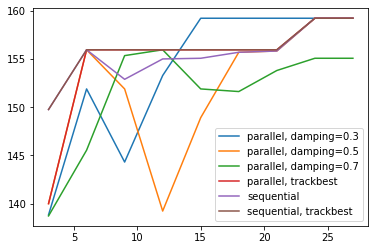

In [55]:
assert CURRENT_CELL == EAXCT_LINEAR_CHAIN

iter_nums = list(range(3, 30, 3))
for damping in [0.3, 0.5, 0.7]:
    energies = []
    for iter_num in iter_nums:
        energies.append(E(labels=lbp_plus(*args, max_iter=iter_num, damping=damping)))
    plt.plot(iter_nums, energies, label=f'parallel, damping={damping}')

energies = []
for iter_num in iter_nums:
    energies.append(E(labels=lbp_plus(*args, max_iter=iter_num, damping=0.5, track_best=True)))
plt.plot(iter_nums, energies, label='parallel, trackbest')

energies = []
for iter_num in iter_nums:
    energies.append(E(labels=iterative_max_product(*args, max_iter=iter_num)))
plt.plot(iter_nums, energies, label='sequential')

energies = []
for iter_num in iter_nums:
    energies.append(E(labels=iterative_max_product(*args, max_iter=iter_num, track_best=True)))
plt.plot(iter_nums, energies, label='sequential, trackbest')

plt.legend()

In [56]:
assert CURRENT_CELL == EAXCT_LINEAR_CHAIN

print(lbp_plus(*args, track_best=True) == inference_max_product(*args))
print(iterative_max_product(*args, track_best=True) == inference_max_product(*args))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False False False  True  True  True  True
  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False False False  True  True  True  True
  True]


## Tests on skip binary linear chain

A-B-C-D-E

- skip-0 binaries: A-B, B-C, ...
- skip-1 binaries: A-C, B-D, ...
- skip-2 binaries: A-D, B-E, ...

In [57]:
SKIP_BINARY_LINEAR_CHAIN = 'SKIP_BINARY_LINEAR_CHAIN'
CURRENT_CELL = SKIP_BINARY_LINEAR_CHAIN

size = 25
n_states = 32

rnd = np.random.RandomState(2)
unary_potentials = np.abs(rnd.normal(loc=0, scale=1, size=(size, n_states)))

binary_edges = np.array(
    [[i, i+1] for i in range(size - 1)] + #
    [[i, i+2] for i in range(size - 2)] + #
    [[i, i+3] for i in range(size - 3)] 
)
binary_potentials = np.abs(rnd.normal(loc=0, scale=2, size=(binary_edges.shape[0], n_states, n_states))) * 2

args = (unary_potentials, binary_potentials, binary_edges)
E = partial(compute_energy_plus, *args)

In [ ]:
assert CURRENT_CELL == SKIP_BINARY_LINEAR_CHAIN

%timeit lbp_plus(*args)
%timeit lbp_plus(*args, max_iter=30, track_best=True)
%timeit iterative_max_product(*args)
%timeit iterative_max_product(*args, max_iter=10, track_best=True)
# %timeit inference_ad3(*args)

In [59]:
assert CURRENT_CELL == SKIP_BINARY_LINEAR_CHAIN

print(E(labels=lbp_plus(*args)))
print("lbp_plus")
print(E(labels=lbp_plus(*args, track_best=True)))
print(E(labels=lbp_plus(*args, max_iter=30, track_best=True)))
print(E(labels=lbp_plus(*args, max_iter=60, track_best=True)))
print("sequential lbp")
print(E(labels=iterative_max_product(*args)))
print(E(labels=iterative_max_product(*args, track_best=True)))
print(E(labels=iterative_max_product(*args, max_iter=30, track_best=True)))
print(E(labels=iterative_max_product(*args, max_iter=60, track_best=True)))
print("ad3")
print(E(labels=inference_ad3(*args)))

386.7405599796169
lbp_plus
436.2091113774191
478.5143477593398
522.3927807321705
sequential lbp
454.7447696096551
486.25091105643554
486.25091105643554
503.9541958911937
ad3
407.3296470050889


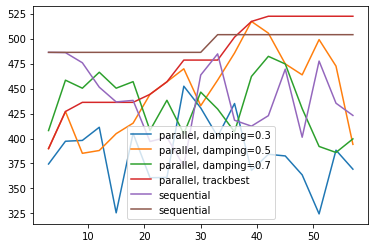

In [60]:
assert CURRENT_CELL == SKIP_BINARY_LINEAR_CHAIN

iter_nums = list(range(3, 60, 3))
for damping in [0.3, 0.5, 0.7]:
    energies = []
    for iter_num in iter_nums:
        energies.append(E(labels=lbp_plus(*args, max_iter=iter_num, damping=damping)))
    plt.plot(iter_nums, energies, label=f'parallel, damping={damping}')

energies = []
for iter_num in iter_nums:
    energies.append(E(labels=lbp_plus(*args, max_iter=iter_num, damping=0.5, track_best=True)))
plt.plot(iter_nums, energies, label='parallel, trackbest')
    
energies = []
for iter_num in iter_nums:
    energies.append(E(labels=iterative_max_product(*args, max_iter=iter_num)))
plt.plot(iter_nums, energies, label='sequential')

energies = []
for iter_num in iter_nums:
    energies.append(E(labels=iterative_max_product(*args, max_iter=iter_num, track_best=True)))
plt.plot(iter_nums, energies, label='sequential')

plt.legend()

# Implementation of LBP with Ternary Potentials

A-B-C-D-E

- binaries: A-B, B-C, ...
- ternaries: A-B-C, B-C-D, ...

In [137]:
TERNARY_LINEAR_CHAIN = 'TERNARY_LINEAR_CHAIN'
CURRENT_CELL = TERNARY_LINEAR_CHAIN


size = 25
n_states = 32

rnd = np.random.RandomState(2)
x = np.abs(rnd.normal(loc=0, scale=1, size=(size, size, n_states)))
unary_potentials = x.reshape(-1, n_states)

binary_edges = np.array([[i, i+1] for i in range(size - 1)])
binary_potentials = np.abs(rnd.normal(loc=0, scale=2, size=(binary_edges.shape[0], n_states, n_states))) * 2

ternary_edges = np.array([[i, i+1, i+2] for i in range(size - 2)])
ternary_potentials = np.abs(rnd.normal(loc=0, scale=4, size=(ternary_edges.shape[0], n_states, n_states, n_states))) * 2


In [129]:
assert CURRENT_CELL == TERNARY_LINEAR_CHAIN

unary_potentials = torch.tensor(unary_potentials, dtype=torch.float32)
binary_potentials = torch.tensor(binary_potentials, dtype=torch.float32)
ternary_potentials = torch.tensor(ternary_potentials, dtype=torch.float32)
binary_edges = torch.tensor(binary_edges, dtype=torch.long)
ternary_edges = torch.tensor(ternary_edges, dtype=torch.long)

bin_args = (unary_potentials, binary_potentials, binary_edges)
ter_args = (unary_potentials, binary_potentials, binary_edges, ternary_potentials, ternary_edges)

label_unary_binary_ternary = lbp_plus(*ter_args, damping=0.5)
print("unary+binary+ternary", compute_energy_plus(*ter_args, label_unary_binary_ternary))

label_unary_binary_ternary = lbp_plus(*ter_args, max_iter=10, damping=0.5, track_best=True)
print("unary+binary+ternary", compute_energy_plus(*ter_args, label_unary_binary_ternary))

label_unary_binary_ternary = lbp_plus(*ter_args, max_iter=30, damping=0.5, track_best=True)
print("unary+binary+ternary", compute_energy_plus(*ter_args, label_unary_binary_ternary))

ValueError: operands could not be broadcast together with shapes (24,) (16,) 

In [180]:
assert CURRENT_CELL == TERNARY_LINEAR_CHAIN

genops.set_backend(genops.NUMPY)

bin_args = (unary_potentials, binary_potentials, binary_edges)
ter_args = (unary_potentials, binary_potentials, binary_edges, ternary_potentials, ternary_edges)

print("only consider binaries")

label_unary = unary_potentials.argmax(axis=1)
print("unary", compute_energy_plus(*ter_args, label_unary))

ps_maxprod = iterative_max_product(*bin_args)
print("pystruct's maxprod", compute_energy_plus(*ter_args, ps_maxprod))

ps_ad3 = inference_ad3(*bin_args)
print("pystruct's ad3", compute_energy_plus(*ter_args, ps_ad3))

label_unary_binary = lbp_plus(*bin_args)
print("unary+binary", compute_energy_plus(*ter_args, label_unary_binary))

print("consider ternaries")

label_unary_binary_ternary = lbp_plus(*ter_args, damping=0.5)
print("unary+binary+ternary", compute_energy_plus(*ter_args, label_unary_binary_ternary))

label_unary_binary_ternary = lbp_plus(*ter_args, max_iter=10, damping=0.5, track_best=True)
print("unary+binary+ternary", compute_energy_plus(*ter_args, label_unary_binary_ternary))

label_unary_binary_ternary = lbp_plus(*ter_args, max_iter=30, damping=0.5, track_best=True)
print("unary+binary+ternary", compute_energy_plus(*ter_args, label_unary_binary_ternary))


only consider binaries
unary 1702.225360320403
pystruct's maxprod 1815.7207334257919
pystruct's ad3 1841.9226360193197
unary+binary 1815.7207334257919
consider ternaries
unary+binary+ternary 2022.3128089477386
unary+binary+ternary 2022.3128089477386
unary+binary+ternary 2043.6646244334265
